## Advanced Algorithmic Trading DT - V13

## Updates from Last Version
- Implement Logistic Regression forecasting for binary predictions

## Contents
- Basic Setup
- Clean Data & Create Technical Indicator Variables
- Standardize Data & Create X & y
- Time Series Train Test Split
    - Bagging
    - Random Forest
    - Boosting
    - Linear Regression
- Misc Graphs
- Hyperparameter Tuning --> Grid Search
- Forecasting w/ Best Models
- Binary Forecasting (confusion matrices, ROC AUC)

#### Import Packages

In [105]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math

import datetime
import gc

from sklearn.ensemble import (BaggingRegressor, RandomForestRegressor, AdaBoostRegressor)
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

from technical_indicators import * # import all function

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression


#### Set Parameters

In [32]:
# Set the random seed, number of estimators and the "step factor" used to plot the graph of MSE for each method
random_state = 42  # Seed
n_jobs = -1 # -1 --> all Processors # Parallelisation factor for bagging, random forests (controls the number of processor cores used)
n_estimators = 200 # total number of estimators ot use in the MSE graph
step_factor = 10 # controls granularity of calculation by stepping through the number of estimators
axis_step = int(n_estimators / step_factor) # 1000/10 = 100 separate calculations will be performed for each of the 3 ensebmle methods

### Set path to save plots
#plot_path = 'C:/Users/meenm/OneDrive - UW-Madison/Github/Stat479_project2/Stat479_Project/Plots/'


#### Read in Data via GitHub URL

In [33]:
url = "https://raw.githubusercontent.com/SamIlic/Forecasting-Stock-Returns-via-Stacking/master/Data/IBM.csv"
df_ORIGINAL = pd.read_csv(url)

In [34]:
display(df_ORIGINAL.head())

,Date,High,Low,Open,Close,Volume,Adj Close
0,1/2/2002,121.500000,119.800003,120.599999,121.500000,6862800,84.677422
1,1/3/2002,124.220001,120.250000,121.500000,123.660004,8621700,86.182800
2,1/4/2002,125.599999,123.980003,124.050003,125.599999,8405200,87.534859
3,1/7/2002,126.190002,123.699997,125.000000,124.050003,5939600,86.454575
4,1/8/2002,125.199997,123.730003,124.250000,124.699997,5311800,86.907600


***
## Clean Data & Create Technical Indicator Variables

- Create Deep copy of dataframe
- Use Adjusted Close Data
- Drop Close 
- Rename "Adj. Close" as "Close"
- Create Lagged Price Variables
- Drop NaN
- Create Technical Indicator Variables
- Drop NaN
- Re-set index as Date

In [35]:
df_features = df_ORIGINAL.copy(deep=True) # Create Deep
df_features.drop(['Close'], axis = 1, inplace = True) # drop close column
df_features.columns = ['Date', 'High', 'Low', 'Open', 'Volume', 'Close'] # Close is actually Adj. Close

df_features['Date'] = pd.to_datetime(df_features['Date'])
#df_features.head() # sanity check


"""
Creates Lagged Returns 
- given OHLCV dataframe
- numer of lagged days
"""
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['Date', 'Close']].copy()
        # generate dataframe to shift index by i day.
        df_lag['Date'] = df_lag['Date'].shift(-i)
        df_lag.columns = ['Date', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['Date'], right_on = ['Date'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['Close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret


### Run Function
df_features = create_lag_features(df_features, 5) # 5 lag features
#df_features.head(7)

# drop earlier data with missing lag features
df_features.dropna(inplace=True)
# reset index
df_features.reset_index(drop = True, inplace = True)


#### GENERATE TECHNICAL INDICATORS FEATURES
df_features = standard_deviation(df_features, 14)

df_features = relative_strength_index(df_features, 14) # periods
df_features = average_directional_movement_index(df_features, 14, 13) # n, n_ADX
df_features = moving_average(df_features, 21) # periods
df_features = exponential_moving_average(df_features, 21) # periods
df_features = momentum(df_features, 14) # 

df_features = average_true_range(df_features, 14)
df_features = bollinger_bands(df_features, 21)
df_features = ppsr(df_features)
df_features = stochastic_oscillator_k(df_features)
df_features = stochastic_oscillator_d(df_features, 14)
df_features = trix(df_features, 14)
df_features = macd(df_features, 26, 12)
df_features = mass_index(df_features)
df_features = vortex_indicator(df_features, 14)

df_features = kst_oscillator(df_features, 10, 10, 10, 15, 10, 15, 20, 30)
df_features = true_strength_index(df_features, 25, 13)

#df_features = accumulation_distribution(df_features, 14) # Causes Problems, apparently
df_features = chaikin_oscillator(df_features)
df_features = money_flow_index(df_features, 14)
df_features = on_balance_volume(df_features, 14)
df_features = force_index(df_features, 14)
df_features = ease_of_movement(df_features, 14)
df_features = commodity_channel_index(df_features, 14)
df_features = keltner_channel(df_features, 14)
df_features = ultimate_oscillator(df_features)
df_features = donchian_channel(df_features, 14)
    
#drop earlier data with missing lag features
df_features.dropna(inplace=True)
df_features = df_features.reset_index(drop = True)



###########################################################################################
# Store Variables now for plots later
daily_index = df_features.index
daily_returns = df_features["Today"]
daily_price   = df_features["Close"]

# Re-set "Date" as the index
df_features = df_features.set_index('Date')

### Sanity Check
df_features.head(10)


,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,lag4,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
Date,,,,,,,,,,,,,,,,,,,,,
2002-03-14,107.949997,106.589996,107.019997,5335500,74.391068,-0.541176,-1.216580,3.097695,0.142742,1.330632,...,0.714286,1.962464e+06,-2.921157e+07,2.286739e-07,0.959960,93.032764,95.832764,90.232765,0.034641,13.389999
2002-03-15,107.449997,105.589996,106.550003,10864100,74.523666,0.178246,-0.541176,-1.216580,3.097695,0.142742,...,0.642857,3.445814e+06,5.695471e+06,2.086708e-07,0.713277,93.570735,96.351449,90.790020,0.031385,13.389999
2002-03-18,108.639999,106.230003,107.099999,5301200,74.216637,-0.411990,0.178246,-0.541176,-1.216580,3.097695,...,0.714286,3.898193e+06,-4.066156e+07,2.500726e-07,0.779588,94.192408,96.916693,91.468123,0.058735,13.389999
2002-03-19,108.050003,106.489998,106.849999,4614800,75.012154,1.071885,-0.411990,0.178246,-0.541176,-1.216580,...,0.714286,3.372200e+06,-4.964177e+07,2.263920e-07,0.762796,94.770295,97.348152,92.192438,0.057835,13.389999
2002-03-20,106.900001,105.489998,106.900001,4844100,73.623466,-1.851283,1.071885,-0.411990,0.178246,-0.541176,...,0.642857,2.459121e+06,-1.593928e+07,2.007584e-07,0.060704,95.249347,97.800775,92.697918,0.026201,13.389999
2002-03-21,106.779999,104.699997,105.699997,5113100,74.516685,1.213226,-1.851283,1.071885,-0.411990,0.178246,...,0.571429,2.074850e+06,-1.411611e+07,1.220918e-07,-0.248791,95.547059,97.918488,93.175630,-0.008129,13.389999
2002-03-22,106.699997,105.070000,106.500000,5507900,73.693192,-1.105114,1.213226,-1.851283,1.071885,-0.411990,...,0.500000,9.123071e+05,1.101343e+06,3.426329e-08,-0.533297,95.592311,97.837311,93.347311,-0.021320,13.389999
2002-03-25,106.660004,103.500000,105.800003,6277900,72.269615,-1.931761,-1.105114,1.213226,-1.851283,1.071885,...,0.428571,1.004036e+06,1.890940e+06,-5.730833e-09,-1.582313,95.545348,97.848920,93.241776,-0.045311,13.389999
2002-03-26,105.699997,102.300003,103.570000,8144000,71.809052,-0.637285,-1.931761,-1.105114,1.213226,-1.851283,...,0.357143,-1.267786e+05,-1.083363e+06,-5.076478e-08,-1.978289,95.397427,97.776713,93.018141,-0.061006,11.739998


## Standardize Data & Create X & y

- Drop all data used to create technical indicators (this is done in the book)
- Then Standardize, necessary for PLS
- Run PLS
- Select Appropriate number of components
- Create X & y


In [36]:
df_features['FutureReturns'] = df_features['Today'].shift(-1)
df_features.dropna(inplace=True)


In [37]:
### Standardize Data
##########################################################################################
# Drop Columns
list_of_columns_to_exclude = ["High", "Low", "Open", "Volume","Close", "FutureReturns"]
X_temp_standardized = df_features.copy(deep=True)
X_temp_standardized.drop(list_of_columns_to_exclude, axis = 1, inplace = True) # drop columns

# Standardize
dates = X_temp_standardized.index # get dates to set as index after data is standardized
names = X_temp_standardized.columns # Get column names first
X_temp_standardized = StandardScaler().fit_transform(X_temp_standardized)

# Convert to DataFrame
X_temp_standardized = pd.DataFrame(X_temp_standardized, columns=names, index=dates)
X = X_temp_standardized


### Get y
##########################################################################################
y_temp = pd.DataFrame(df_features["FutureReturns"], index=X.index) # can only standardize a dataframe
sc = StandardScaler()
y = sc.fit_transform(y_temp) # Standardize, cause we did it for our original variables
y = pd.DataFrame(y, index=X.index, columns=["FutureReturns"]) # convert back to dataframe
y = y["FutureReturns"] # now re-get y as a Pandas Series

### Sanity Check
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

# Check Types
print(type(X)) # Needs to be <class 'pandas.core.frame.DataFrame'>
print(type(y)) # Needs ro be <class 'pandas.core.series.Series'>

Shape of X:  (4189, 43)
Shape of y:  (4189,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


#### Split: Train & Validatte / Test

- Train & Validate: < '2018-01-01'
- Test: >= '2018-01-01'

In [38]:
X_train_all = X.loc[(X.index < '2018-01-01')]
y_train_all = y[X_train_all.index]

# # creates all test data which is all after January 2018
X_test = X.loc[(X.index >= '2018-01-01'),:]
y_test = y[X_test.index]

### Sanity Check
print("Shape of X_train_all: ", X_train_all.shape)
print("Shape of y_train_all: ", y_train_all.shape)
print("Shape of X_test:      ", X_test.shape)
print("Shape of y_test:      ", y_test.shape)

Shape of X_train_all:  (3979, 43)
Shape of y_train_all:  (3979,)
Shape of X_test:       (210, 43)
Shape of y_test:       (210,)


### Misc. Graphs ---- Price, Returns & Cumulative Returns

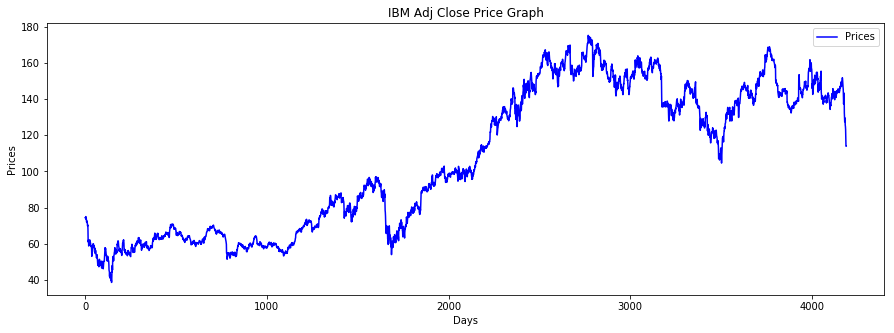

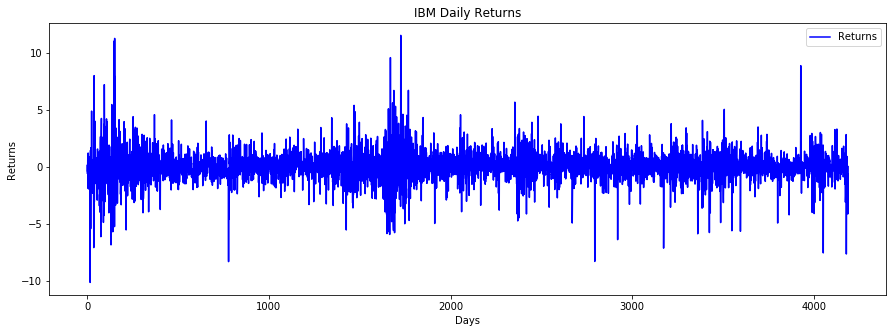

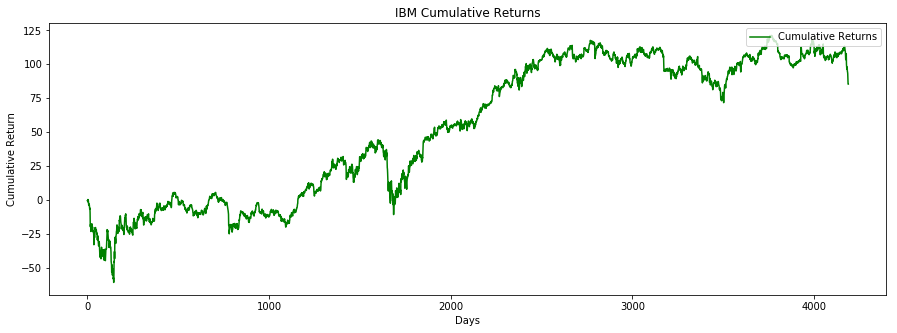

In [39]:
# figure dimenstions
length = 15
height = 5

### Prices
plt.figure(figsize=(length, height))
plt.title('IBM Adj Close Price Graph')
plt.plot(daily_index, daily_price, 'b-', color="blue", label='Prices')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Prices')
#plt.savefig(plot_path+'IBM Adj Close Price Graph')
plt.show()

### Returns
plt.figure(figsize=(length, height))
plt.title('IBM Daily Returns')
plt.plot(daily_index, daily_returns, 'b-', color="blue", label='Returns')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Returns')
#plt.savefig(plot_path+'IBM Daily Returns')
plt.show()

### Cumulative Returns
plt.figure(figsize=(length, height))
plt.title('IBM Cumulative Returns')
cumulative_returns = daily_returns.cumsum()
plt.plot(daily_index, cumulative_returns, 'b-', color="green", label='Cumulative Returns')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
#plt.savefig(plot_path+'IBM Cumulative Returns')
plt.show()

### First - A Note on R-Squared

##### What Does A Negative R Squared Value Mean?

- What does R-squared tell us?
    - It tells us whether a horizonal line through the vertical mean of the data is a better predictor
- For a Linear Regression
    - R-squared is just the coreelation coefficient squared
    - R-squared can't be negative, becasue at 0, it becomes the horizontal line
- For All other Model
    - For practical purposes, the lowest R2 you can get is zero, but only because the assumption is that if your regression line is not better than using the mean, then you will just use the mean value.  
    - However if your regression line is worse than using the mean value, the r squared value that you calculate will be negative.
    - Note that the reason R2 can't be negative in the linear regression case is just due to chance and how linear regression is contructed
    

***  
***  
***  

## Grid Search for Best Model via Time Series Train-Test Split

## Revised RandomForest

In [40]:
"""
Execute Random Forest for differnt number of Time Series Splits
Parameters
    - numSplits: Number of Train/Validation splits to run in order to compute our final model (bigger --> more accurate & more complex)
    - maxDepth: Max Depth of the DT
    - minSamplesSplit: min samples to split (basically pruning)
    
Returns
    - Average R-Squared of the DT model across all Train/Validation splits
"""
def Call_Random_Forest_Grid_Search(numSplits, minSamplesSplit, maxDepth):
    ### Prepare Random Forest
    ##############################################################################
    # Initialize Random Forest Instance
    rf_mse = [] # MSE
    rf_r2 = [] # R2
    rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=123, max_features="sqrt", 
                                   max_depth=maxDepth, 
                                   min_samples_split=minSamplesSplit)

    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

        ### Run Random Forest
        rf.fit(X_train, y_train)
        prediction = rf.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        rf_mse.append(mse)
        rf_r2.append(r2)

    return np.mean(rf_mse), np.mean(rf_r2)

In [51]:
# Call_Random_Forest_Grid_Search(numSplits, minSamplessplit, maxDepth)

minSamplesSplit_list  = [5,8,9,10,11]
maxDepth_list        = [1,2,3]

best_model_parameters = [0,0]
best_model_param_mse = [0,0]
max_r2 = -100
min_mse = 100
count = 0

rf_df = pd.DataFrame()
# Loop over all possible parameters
for minSamplesSplit in minSamplesSplit_list:
    for maxDepth in maxDepth_list:
        count += 1
        temp_mean_mse, temp_mean_r2 = Call_Random_Forest_Grid_Search(10, minSamplesSplit, maxDepth) # Call Random Forest Train/Validation
        print("temp_mean ", count, ": ",  temp_mean_r2)
        if temp_mean_r2 > max_r2:
            max_r2 = temp_mean_r2 # store new max
            best_model_parameters[0] = minSamplesSplit
            best_model_parameters[1] = maxDepth
        if temp_mean_mse < min_mse:
            min_mse = temp_mean_mse
            best_model_param_mse[0] = minSamplesSplit
            best_model_param_mse[1] = maxDepth
            
        rf_df.loc[count,'min_sample_split'] = minSamplesSplit
        rf_df.loc[count,'max_depth'] = maxDepth
        rf_df.loc[count,'mean_r2'] = temp_mean_r2
        rf_df.loc[count, 'mearn_mse'] = temp_mean_mse

print("Best R2: ", max_r2) 
print(best_model_parameters)
print("Best MSE: ", min_mse) 
print(best_model_param_mse)

temp_mean  1 :  -0.010920784734883726
temp_mean  2 :  -0.028702067746212413
temp_mean  3 :  -0.045919070092027045
temp_mean  4 :  -0.010920784734883726
temp_mean  5 :  -0.029151263498484827
temp_mean  6 :  -0.049722822882590986
temp_mean  7 :  -0.010920784734883716
temp_mean  8 :  -0.029512756041345446
temp_mean  9 :  -0.049727288559437345
temp_mean  10 :  -0.010920784734883716
temp_mean  11 :  -0.029389076167676408
temp_mean  12 :  -0.05045652956659041
temp_mean  13 :  -0.010920784734883716
temp_mean  14 :  -0.029130280324340795
temp_mean  15 :  -0.05008465479872014
Best R2:  -0.010920784734883716
[9, 1]
Best MSE:  0.8322248889654371
[5, 1]


## Best Model RF
 - min_samples_split = 10
 - max_depth = 15
 
##### NEW
 - min_samples_split = 9
 - max_depth = 1

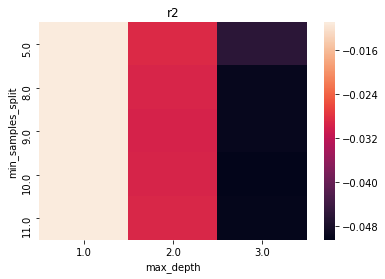

In [52]:
import seaborn as sns

# plot nicely
x_index = np.unique(rf_df.loc[:,'min_sample_split'])
y_index = np.unique((rf_df.loc[:,'max_depth']))
a = pd.DataFrame(index = x_index, columns = y_index)

for i in x_index:
    for j in y_index:
        a.loc[i,j] = list(rf_df.loc[(rf_df['min_sample_split'] == i) & (rf_df['max_depth'] == j),'mean_r2'])[0]#.astype(float)
a = a.apply(pd.to_numeric)    
sns.heatmap(a)
plt.xlabel('max_depth')
plt.ylabel('min_samples_split')
plt.title('r2')
#plt.savefig(plot_path+'Best_Model_RF')
plt.show()

### Bagging

In [53]:

"""
Execute Bagging for differnt number of Time Series Splits
Parameters
    - numSplits: Number of Train/Validation splits to run in order to compute our final model (bigger --> more accurate & more complex)
    - min_samples_split: minimum samples to split
    - max_depth: depth of tree
    
Returns
    - Average R-Squared of the DT model across all Train/Validation splits"""
def Call_Bagging_Grid_Search(numSplits, min_samples_split, max_depth):
    ### Prepare Bagging
    ##############################################################################
    # Initialize Bagging Instance
    bagging_mse = [] # MSE
    bagging_r2 = [] # R2
    bagging = BaggingRegressor(DecisionTreeRegressor(min_samples_split = min_samples_split, max_depth = max_depth),
                               n_estimators=150, random_state=123,
                               #n_jobs = -1,
                                  max_samples=100,
                                  max_features=20)
#     bagging = BaggingRegressor(n_estimators=150, n_jobs=-1, random_state=123)

    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

        ### Run Bagging
        bagging.fit(X_train, y_train)
        prediction = bagging.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)
        

        bagging_mse.append(mse)
        bagging_r2.append(r2)

    return np.mean(bagging_mse), np.mean(bagging_r2)

In [57]:
min_sample_split = [9,10,11]
max_depth = [22,23,24]

best_model_parameters_bag = [0,0]
best_model_param_bag_mse = [0,0]
max_r2_bag = -100
min_mse_bag = 100
count = 0

bag_df = pd.DataFrame()
# Loop over all possible parameters
for minSampleSplit in min_sample_split:
    for maxDepth in max_depth:
        count += 1
        temp_mean_mse, temp_mean_r2 = Call_Bagging_Grid_Search(10, minSampleSplit, maxDepth) # Call Boosting Train/Validation
        print("temp_mean ", count, ": ",  temp_mean_r2)
        if temp_mean_r2 > max_r2_bag:
            max_r2_bag = temp_mean_r2 # store new max
            best_model_parameters_bag[0] = minSampleSplit
            best_model_parameters_bag[1] = maxDepth
        if temp_mean_mse < min_mse_bag:
            min_mse_bag = temp_mean_mse # store new max
            best_model_param_bag_mse[0] = minSampleSplit
            best_model_param_bag_mse[1] = maxDepth
        
        bag_df.loc[count,'min_sample_split'] = minSampleSplit
        bag_df.loc[count,'max_depth'] = maxDepth
        bag_df.loc[count,'mean_r2'] = temp_mean_r2
        bag_df.loc[count, 'mean_mse'] = temp_mean_mse
                

print("Best R2: ", max_r2_bag) 
print(best_model_parameters_bag)
print("Best MSE: ", min_mse_bag) 
print(best_model_param_bag_mse)            

temp_mean  1 :  -0.05323428454375084
temp_mean  2 :  -0.05323425833521728
temp_mean  3 :  -0.05323425833521728
temp_mean  4 :  -0.05158466870529976
temp_mean  5 :  -0.05158367498898468
temp_mean  6 :  -0.05158367498898468
temp_mean  7 :  -0.05656229067465476
temp_mean  8 :  -0.056523997331583295
temp_mean  9 :  -0.056523997331583295
Best R2:  -0.05158367498898468
[10, 23]
Best MSE:  0.8540152196008318
[10, 23]


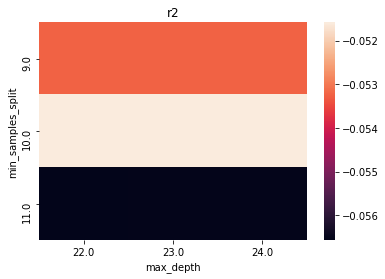

In [58]:
import seaborn as sns

# plot nicely
x_index = np.unique(bag_df.loc[:,'min_sample_split'])
y_index = np.unique((bag_df.loc[:,'max_depth']))
a = pd.DataFrame(index = x_index, columns = y_index)

for i in x_index:
    for j in y_index:
        a.loc[i,j] = list(bag_df.loc[(bag_df['min_sample_split'] == i) & (bag_df['max_depth'] == j),'mean_r2'])[0]#.astype(float)
a = a.apply(pd.to_numeric)    
sns.heatmap(a)
plt.xlabel('max_depth')
plt.ylabel('min_samples_split')
plt.title('r2')
#plt.savefig(plot_path+'Best_Model_Bagging')
plt.show()

# Best Model: Bagging

##### According to Grid Search, our best model is:
- minsampleleaf = 10
- maxdepth = 15
- I had to put max-samples as 100, because some of the split has max samples of only slightly over 100

##### NEW
- minsampleleaf = 10
- maxdepth = 23
- I had to put max-samples as 100, because some of the split has max samples of only slightly over 100

# AdaBoost

In [59]:
"""
Execute Boosting for differnt number of Time Series Splits
Parameters
    - numSplits: Number of Train/Validation splits to run in order to compute our final model (bigger --> more accurate & more complex)
    - min_samples_split: Mininum number of samples to split. if a leaf node has greater than this parameter, we can still split
    - max_depth: depth of tree
    - learning_rate: gradient descent alpha
    
Returns
    - Average R-Squared of the DT model across all Train/Validation splits"""
def Call_Boosting_Grid_Search(numSplits, min_samples_split, max_depth, learning_rate):
    ### Prepare Boosting
    ##############################################################################
    # Initialize Bagging Instance
    boost_mse = [] # MSE
    boost_r2 = [] # R2
    boost = AdaBoostRegressor(DecisionTreeRegressor(max_features = 'sqrt', random_state = 123, min_samples_split = min_samples_split,
                                                   max_depth = max_depth),
                                 n_estimators=150, random_state=123,learning_rate=learning_rate)


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]


        ### Run Boosting
        boost.fit(X_train, y_train)
        prediction = boost.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)
        

        boost_mse.append(mse)
        boost_r2.append(r2)

    return np.mean(boost_mse),np.mean(boost_r2)

In [64]:
### WARNING TAKES VERY LONG TO RUN
min_sample_split = [4,5,6]
max_depth = [1,2,3]
learning_rate = [0.01,0.005]

best_model_parameters_boost = [0,0,0]
best_model_param_boost_mse = [0,0,0]
max_r2_boosting = -100
min_mse_boosting = 100
count = 0

boosting_df = pd.DataFrame()
# Loop over all possible parameters
for minSampleSplit in min_sample_split:
    for maxDepth in max_depth:
        for learn in learning_rate:
            count += 1
            temp_mean_mse, temp_mean_r2 = Call_Boosting_Grid_Search(10, minSampleSplit, maxDepth, learn) # Call Boosting Train/Validation
            print("temp_mean ", count, ": ",  temp_mean_r2)
            if temp_mean_r2 > max_r2_boosting:
                max_r2_boosting = temp_mean_r2 # store new max
                best_model_parameters_boost[0] = minSampleSplit
                best_model_parameters_boost[1] = maxDepth
                best_model_parameters_boost[2] = learn
            if temp_mean_mse < min_mse_boosting:
                min_mse_boosting = temp_mean_mse # store new max
                best_model_param_boost_mse[0] = minSampleSplit
                best_model_param_boost_mse[1] = maxDepth
                best_model_param_boost_mse[2] = learn
            boosting_df.loc[count,'min_sample_split'] = minSampleSplit
            boosting_df.loc[count,'max_depth'] = maxDepth
            boosting_df.loc[count, 'Learning_rate'] = learn
            boosting_df.loc[count,'mean_r2'] = temp_mean_r2
                
print("Best R2: ", max_r2_boosting) 
print(best_model_parameters_boost)
print("Best MSE: ", min_mse_boosting) 
print(best_model_param_boost_mse)

temp_mean  1 :  -0.009063421330822696
temp_mean  2 :  -0.007386860156762642
temp_mean  3 :  -0.010091815957027472
temp_mean  4 :  -0.009436335629456805
temp_mean  5 :  -0.00993873239274785
temp_mean  6 :  -0.00888253774212382
temp_mean  7 :  -0.009063421330822696
temp_mean  8 :  -0.007386860156762642
temp_mean  9 :  -0.009319333210134739
temp_mean  10 :  -0.008449005624261841
temp_mean  11 :  -0.010765170993871209
temp_mean  12 :  -0.009683485631485689
temp_mean  13 :  -0.009063421330822696
temp_mean  14 :  -0.007386860156762642
temp_mean  15 :  -0.00932553081749723
temp_mean  16 :  -0.008831135738658402
temp_mean  17 :  -0.010804571039832211
temp_mean  18 :  -0.008571375885284671
Best R2:  -0.007386860156762642
[5, 1, 0.005]
Best MSE:  0.826661064958318
[5, 1, 0.005]


In [65]:
display(boosting_df)

,min_sample_split,max_depth,Learning_rate,mean_r2
1,5.0,1.0,0.010,-0.009063
2,5.0,1.0,0.005,-0.007387
3,5.0,2.0,0.010,-0.010092
4,5.0,2.0,0.005,-0.009436
5,5.0,3.0,0.010,-0.009939
6,5.0,3.0,0.005,-0.008883
7,6.0,1.0,0.010,-0.009063
8,6.0,1.0,0.005,-0.007387
9,6.0,2.0,0.010,-0.009319
10,6.0,2.0,0.005,-0.008449


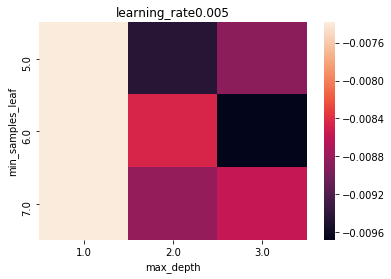

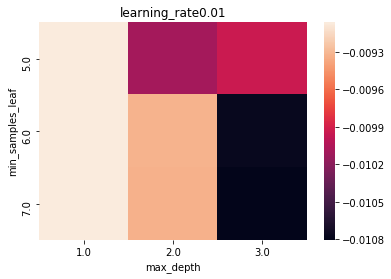

In [66]:
import seaborn as sns
import numpy as np

# plot nicely


p = 0
for learn in (np.unique(boosting_df.loc[:,'Learning_rate'])):

    x_index = np.unique(boosting_df.loc[:,'min_sample_split'])
    y_index = np.unique((boosting_df.loc[:,'max_depth']))
    a = pd.DataFrame(index = x_index, columns = y_index)
    
    for i in x_index:
        for j in y_index:
            a.loc[i,j] = list(boosting_df.loc[(boosting_df['min_sample_split'] == i) & (boosting_df['max_depth'] == j) & (boosting_df['Learning_rate'] == learn),'mean_r2'])[0]#.astype(float)
    a = a.apply(pd.to_numeric)    
    sns.heatmap(a)
    #plt.savefig(plot_path+'Best_Model_Boosting_'+str(p))
    p+=1
   # f, (ax1,ax2,ax3) = matplotlib.pyplot.subplots(1, 3)
    
    
    plt.title('learning_rate' + str(learn))
    plt.xlabel('max_depth')
    plt.ylabel('min_samples_leaf')
    plt.show()

## Best Model:

#### According to Grid Search, our best model is:
- min_samples_leaf = 5
- max_depth = 5
- learning_rate = 0.01

##### NEW
- min_samples_leaf = 5
- max_depth = 1
- learning_rate = 0.005


# Linear Regression

In [67]:
"""
Execute LR for differnt number of Time Series Splits
Parameters
    - numSplits: Number of Train/Validation splits to run in order to compute our final model (bigger --> more accurate & more complex)
    
Returns
    - Average R-Squared of the DT model across all Train/Validation splits"""
def Call_LR_Grid_Search(numSplits):
    ### Prepare LR
    ##############################################################################
    # Initialize Bagging Instance
    lr_mse = [] # MSE
    lr_r2 = [] # R2
    lr = LinearRegression()


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]


        ### Run Boosting
        lr.fit(X_train, y_train)
        prediction = lr.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)
        

        lr_mse.append(mse)
        lr_r2.append(r2)

    return np.mean(lr_mse),np.mean(lr_r2)

In [68]:
lr_mse, lr_r2 = Call_LR_Grid_Search(10)
print("MSE: ", lr_mse)
print('r2:', lr_r2)

MSE:  1.1510115355188826
r2: -0.5309692829311492


***
# FINAL PREDICTION

In [82]:
rf_train_pred = []
bag_train_pred = []
boost_train_pred = []
lr_train_pred = []
rf_prediction = []
bag_prediction = []
boost_prediction = []
lr_prediction = []

#### Set Final Model Parameters

In [83]:
### Number of Testing Splits/Times we Re-train the model on latest data
N = 10

### Random Forest
max_depth_rf = 30
min_samples_split_rf = 2

### Bagging
max_depth_bagging = 15
min_samples_split_bagging = 5
max_samples_bagging = 1500
max_features = 20

### Boosting
max_depth_boosting = 5
min_samples_split_boosting = 5
learning_rate = 1

####################################
# ### Random Forest
# min_samples_split_rf = 9
# max_depth_rf = 1

# ### Bagging
# min_samples_split_bagging = 10
# max_depth_bagging = 23
# max_samples_bagging = 1500
# max_features = 20

# ### Boosting
# max_depth_boosting = 1
# min_samples_split_boosting = 5
# learning_rate = 0.001

#### Run Final Models (Random Forest, Bagging, Boosting)

In [84]:
## WARNING Takes long to run
splits = TimeSeriesSplit(n_splits=N)

rf = RandomForestRegressor(n_estimators=150, 
                           #n_jobs=-1, 
                           random_state=123, max_features="sqrt", 
                                   max_depth=max_depth_rf, 
                                   min_samples_split=min_samples_split_rf)

bag = BaggingRegressor(DecisionTreeRegressor(max_features = 'sqrt', random_state = 123, 
                                             max_depth = max_depth_bagging, 
                                             min_samples_split = min_samples_split_bagging),
                                   n_estimators=150, 
                                   #n_jobs=-1, 
                                   random_state=123,
                                   max_samples=max_samples_bagging,
                                   max_features=max_features)

boost = AdaBoostRegressor(DecisionTreeRegressor(max_features = 'sqrt', random_state = 123, 
                                                    max_depth = max_depth_boosting,
                                               min_samples_split = min_samples_split_boosting),
                                   n_estimators=150, 
                                   random_state=123,
                                   learning_rate=learning_rate)

lr = LinearRegression()


# predict first fold of test set, need to change 21 if using different than 10 cv
### Run Random Forest
rf.fit(X_train_all, y_train_all)
prediction = rf.predict(X_test.iloc[0:20,:])
rf_prediction.append(prediction)
rf_train_pred.append(rf.predict(X_train_all))

# y_val = y[X_test.iloc[0:21,:].index]

# mse = mean_squared_error(y_val, prediction)
# r2  = r2_score(y_val, prediction)

# ### Run bagging
bag.fit(X_train_all, y_train_all)
prediction = bag.predict(X_test.iloc[0:20,:])
bag_prediction.append(prediction)
bag_train_pred.append(bag.predict(X_train_all))


# y_val = y[X_test.iloc[0:21,:].index]

# mse = mean_squared_error(y_val, prediction)
# r2  = r2_score(y_val, prediction)

## Run boosting
boost.fit(X_train_all, y_train_all)
prediction = boost.predict(X_test.iloc[0:20,:])
boost_prediction.append(prediction)
boost_train_pred.append(boost.predict(X_train_all))

# y_val = y[X_test.iloc[0:21,:].index]

# mse = mean_squared_error(y_val, prediction)
# r2  = r2_score(y_val, prediction)

## Run lr
lr.fit(X_train_all, y_train_all)
prediction = lr.predict(X_test.iloc[0:20,:])
lr_prediction.append(prediction)
lr_train_pred.append(lr.predict(X_train_all))


# y_val = y[X_test.iloc[0:21,:].index]


splitCount = 0
for train_index, test_index in splits.split(X_test):
    splitCount += 1
    
    # Calculate NEW Train/Test indices
    train_index = X_train_all.shape[0] + len(train_index)
    
    # Train Split
    X_train = X.iloc[0:train_index,:]
    y_train = y[X_train.index]
        
    # Validate Split
    X_val = X_test.iloc[test_index[0]:(test_index[-1]+1),:]
    y_val = y[X_val.index]
        
    ### Run Random Forest
    rf.fit(X_train, y_train)
    prediction = rf.predict(X_val)
    rf_prediction.append(prediction)
    rf_train_pred.append(rf.predict(X_train))

    
#     mse = mean_squared_error(y_val, prediction)
#     r2  = r2_score(y_val, prediction)

#     rf_metrics.append([mse,r2])
    
    ### Run bagging
    bag.fit(X_train, y_train)
    prediction = bag.predict(X_val)
    bag_prediction.append(prediction)
    bag_train_pred.append(bag.predict(X_train))


    
#     mse = mean_squared_error(y_val, prediction)
#     r2  = r2_score(y_val, prediction)

#     bag_metrics.append([mse,r2])
    
    ## Run boosting
    boost.fit(X_train, y_train)
    prediction = boost.predict(X_val)
    boost_prediction.append(prediction)
    boost_train_pred.append(boost.predict(X_train))


#     mse = mean_squared_error(y_val, prediction)
#     r2  = r2_score(y_val, prediction)

#     boost_metrics.append([mse,r2])

    ## Linear Regression
    lr.fit(X_train, y_train)
    prediction = lr.predict(X_val)
    lr_prediction.append(prediction)
    lr_train_pred.append(lr.predict(X_train))

    
    print(splitCount)

1
2
3
4
5
6
7
8
9
10


In [85]:
#make into one array instead of 10x10 matrix
rf_prediction = np.array(rf_prediction)
rf_prediction = np.concatenate(rf_prediction, axis=0)
bag_prediction = np.array(bag_prediction)
bag_prediction = np.concatenate(bag_prediction, axis=0)
boost_prediction = np.array(boost_prediction)
boost_prediction = np.concatenate(boost_prediction, axis=0)
lr_prediction = np.array(lr_prediction)
lr_prediction = np.concatenate(lr_prediction, axis=0)

In [86]:
# evaluate 
rf_mse = mean_squared_error(y_test[0:210], rf_prediction)
rf_r2  = r2_score(y_test[0:210], rf_prediction)
bag_mse = mean_squared_error(y_test[0:210], bag_prediction)
bag_r2  = r2_score(y_test[0:210], bag_prediction)
boost_mse = mean_squared_error(y_test[0:210], boost_prediction)
boost_r2  = r2_score(y_test[0:210], boost_prediction)
lr_mse = mean_squared_error(y_test[0:210], lr_prediction)
lr_r2  = r2_score(y_test[0:210], lr_prediction)

print('rf_mse:', rf_mse)
print('rf_r2:', rf_r2)
print('bag_mse:', bag_mse)
print('bag_r2:', bag_r2)
print('boost_mse:', boost_mse)
print('boost_r2:', boost_r2)
print('lr_mse:', lr_mse)
print('lr_r2:', lr_r2)

rf_mse: 1.1418903041506858
rf_r2: -0.07174464520517954
bag_mse: 1.1259033778581453
bag_r2: -0.05673978652038314
boost_mse: 1.1036765910737654
boost_r2: -0.035878378353865426
lr_mse: 1.3340799611312022
lr_r2: -0.25212820305129946


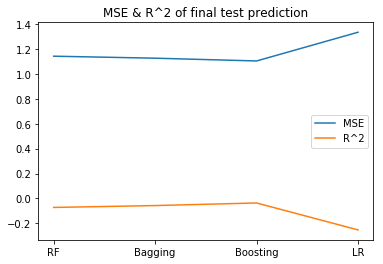

In [87]:
plt.plot(['RF','Bagging','Boosting', 'LR'],[rf_mse, bag_mse, boost_mse, lr_mse],label='MSE')
plt.plot([rf_r2, bag_r2, boost_r2, lr_r2],label='R^2')
plt.legend()
plt.title('MSE & R^2 of final test prediction')
#plt.savefig(plot_path+'MSE_R2_linear_pred')
plt.show()

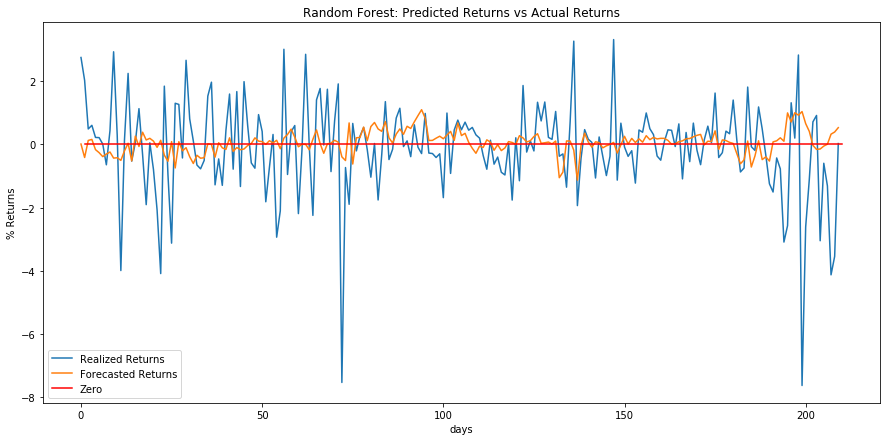

In [88]:
# plot Random Forest
plt.figure(figsize=(15, 7))
plt.plot(sc.inverse_transform(np.array(y_test)))
plt.plot(sc.inverse_transform(rf_prediction))
plt.plot(list(range(1,210+1)), np.array([0] * 210), 'b-', color="red", label='Zero')
plt.legend(["Realized Returns","Forecasted Returns","Zero"])

plt.ylabel('% Returns')
plt.xlabel('days')
plt.title('Random Forest: Predicted Returns vs Actual Returns')
#plt.savefig(plot_path+'RF_Predicted_Returns_Actual_Returns')
plt.show()

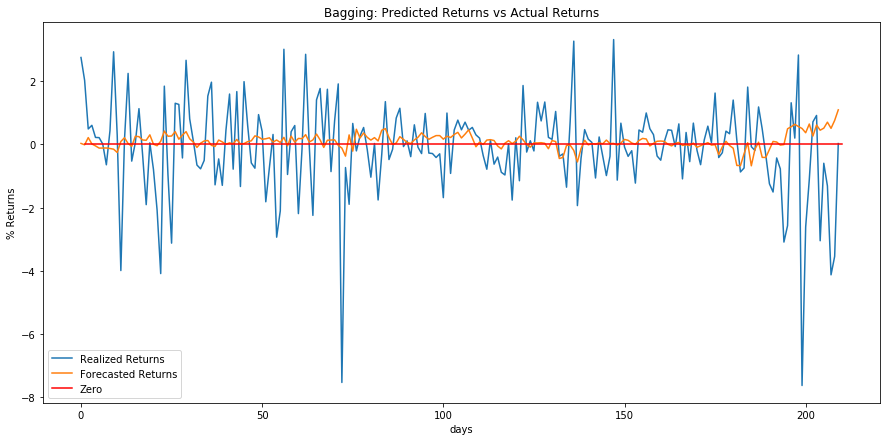

In [89]:
# plot Bagging
plt.figure(figsize=(15, 7))
plt.plot(sc.inverse_transform(np.array(y_test)))
plt.plot(sc.inverse_transform(bag_prediction))
plt.plot(list(range(1,210+1)), np.array([0] * 210), 'b-', color="red", label='Zero')
plt.legend(["Realized Returns","Forecasted Returns","Zero"])

plt.ylabel('% Returns')
plt.xlabel('days')
plt.title('Bagging: Predicted Returns vs Actual Returns')
#plt.savefig(plot_path+'Bagging_Predicted_Returns_Actual_Returns')
plt.show()

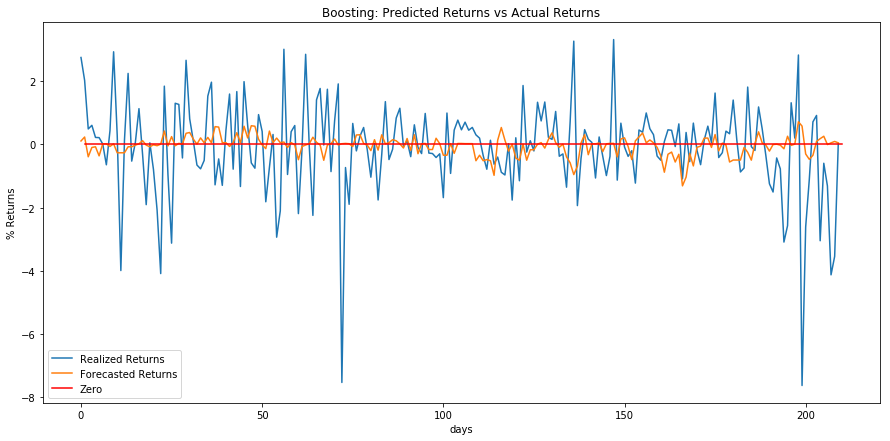

In [90]:
# plot Boosting
plt.figure(figsize=(15, 7))
plt.plot(sc.inverse_transform(np.array(y_test)))
plt.plot(sc.inverse_transform(boost_prediction))
plt.plot(list(range(1,210+1)), np.array([0] * 210), 'b-', color="red", label='Zero')
plt.legend(["Realized Returns","Forecasted Returns","Zero"])


plt.ylabel('% Returns')
plt.xlabel('days')
plt.title('Boosting: Predicted Returns vs Actual Returns')
#plt.savefig(plot_path+'Boosting_Predicted_Returns_Actual_Returns')
plt.show()

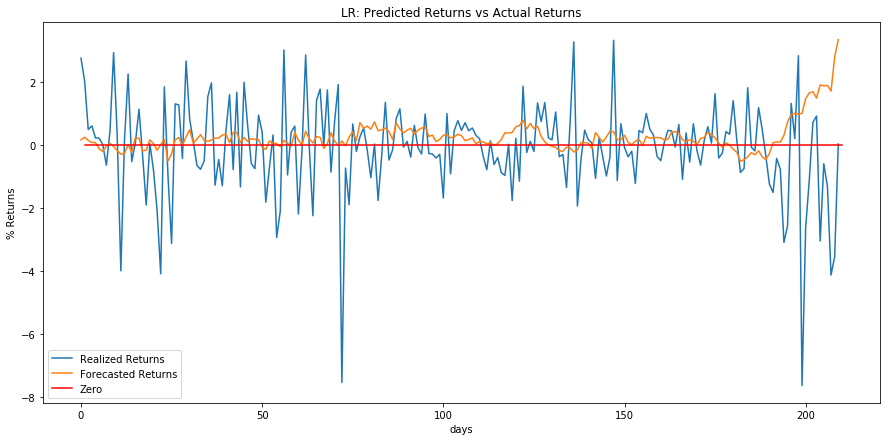

In [91]:
# plot best model which is LR
plt.figure(figsize=(15, 7))
plt.plot(sc.inverse_transform(np.array(y_test)))
plt.plot(sc.inverse_transform(lr_prediction))
plt.plot(list(range(1,210+1)), np.array([0] * 210), 'b-', color="red", label='Zero')
plt.legend(["Realized Returns","Forecasted Returns","Zero"])


plt.ylabel('% Returns')
plt.xlabel('days')
plt.title('LR: Predicted Returns vs Actual Returns')
#plt.savefig(plot_path+'LR_Predicted_Returns_Actual_Returns')
plt.show()

In [92]:
X_train.columns

Index(['Today', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'STD_14', 'RSI_14',
       'ADX_14_13', 'MA_21', 'EMA_21', 'Momentum_14', 'ATR_14',
       'BollingerB_21', 'Bollinger%b_21', 'PP', 'R1', 'S1', 'R2', 'S2', 'R3',
       'S3', 'SO%k', 'SO%d_14', 'Trix_14', 'MACD_26_12', 'MACDsign_26_12',
       'MACDdiff_26_12', 'Mass Index', 'Vortex_14',
       'KST_10_10_10_15_10_15_20_30', 'TSI_25_13', 'Chaikin', 'MFI_14',
       'OBV_14', 'Force_14', 'EoM_14', 'CCI_14', 'KelChM_14', 'KelChU_14',
       'KelChD_14', 'Ultimate_Osc', 'Donchian_14'],
      dtype='object')

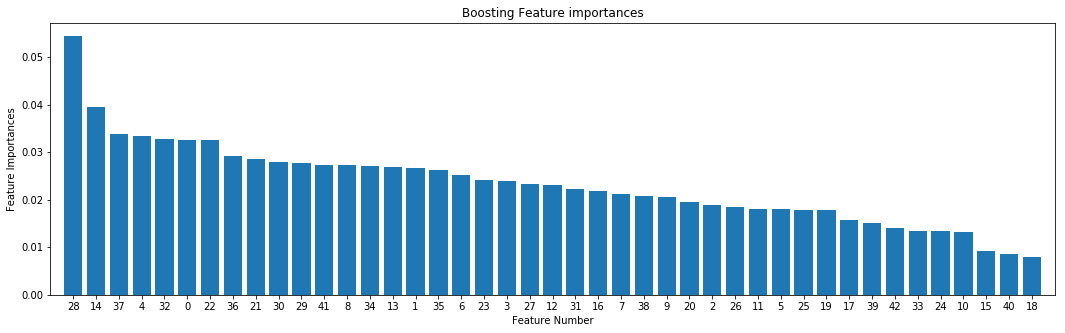

In [93]:
importances = boost.feature_importances_
indices = np.argsort(importances)[::-1]
#plot_path = 'C:/Users/meenm/OneDrive - UW-Madison/Github/Stat479_project2/Stat479_Project/Plots/'

# Plot the feature importances of the forest
plt.figure(figsize=(18,5))
plt.title("Boosting Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices])
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel('Feature Importances')
plt.xlabel('Feature Number')
#plt.savefig(plot_path+'Boosting_Feature_Importance.png')
plt.show()

In [94]:
boost.feature_importances_

array([0.03250659, 0.0267075 , 0.01880823, 0.02403045, 0.03347879,
       0.01797379, 0.02526568, 0.02114581, 0.02736605, 0.02047875,
       0.01326775, 0.01798592, 0.02320377, 0.02696006, 0.03951568,
       0.00929814, 0.02179156, 0.01573737, 0.00790446, 0.01784705,
       0.01962778, 0.02860892, 0.03247151, 0.02421917, 0.0133316 ,
       0.01788481, 0.01839173, 0.02321233, 0.05445984, 0.02765203,
       0.02800707, 0.02225196, 0.03277567, 0.01340652, 0.02718317,
       0.0262935 , 0.02930327, 0.03393481, 0.02069026, 0.01504735,
       0.00853023, 0.02738478, 0.01405828])

In [95]:
# RF Prediction
correct = 0

conf_mat_rf = np.array([[0,0],[0,0]])

for ind, i in enumerate(rf_prediction):
    if rf_prediction[ind] <= 0 and y_test[ind] <= 0:
        correct = correct + 1
        conf_mat_rf[0,0] = conf_mat_rf[0,0] + 1
    elif rf_prediction[ind] >= 0 and y_test[ind] >= 0:
        correct = correct + 1
        conf_mat_rf[1,1] = conf_mat_rf[1,1] + 1
    elif rf_prediction[ind] >= 0 and y_test[ind] < 0:
        conf_mat_rf[1,0] = conf_mat_rf[1,0] + 1
    elif rf_prediction[ind] <=0 and y_test[ind] > 0:
        conf_mat_rf[0,1] = conf_mat_rf[0,1] + 1
    
print('Accuracy', correct/210)
print(conf_mat_rf)

Accuracy 0.5476190476190477
[[47 37]
 [58 68]]


In [96]:
# Bag Prediction
correct = 0

conf_mat_bag = np.array([[0,0],[0,0]])

for ind, i in enumerate(bag_prediction):
    if bag_prediction[ind] <= 0 and y_test[ind] <= 0:
        correct = correct + 1
        conf_mat_bag[0,0] = conf_mat_bag[0,0] + 1
    elif bag_prediction[ind] >= 0 and y_test[ind] >= 0:
        correct = correct + 1
        conf_mat_bag[1,1] = conf_mat_bag[1,1] + 1
    elif bag_prediction[ind] >= 0 and y_test[ind] < 0:
        conf_mat_bag[1,0] = conf_mat_bag[1,0] + 1
    elif bag_prediction[ind] <=0 and y_test[ind] > 0:
        conf_mat_bag[0,1] = conf_mat_bag[0,1] + 1
    
print('Accuracy', correct/210)
print(conf_mat_bag)

Accuracy 0.5619047619047619
[[41 28]
 [64 77]]


In [97]:
# BINARY PREDICTION ACCURATE 53.3% of time for boosting 
correct = 0

conf_mat_boost = np.array([[0,0],[0,0]])

for ind, i in enumerate(boost_prediction):
    if boost_prediction[ind] >= 0 and y_test[ind] >= 0:
        correct = correct + 1
        conf_mat_boost[0,0] = conf_mat_boost[0,0] + 1
    elif boost_prediction[ind] <= 0 and y_test[ind] <= 0:
        correct = correct + 1
        conf_mat_boost[1,1] = conf_mat_boost[1,1] + 1
    elif boost_prediction[ind] >= 0 and y_test[ind] < 0:
        conf_mat_boost[1,0] = conf_mat_boost[1,0] + 1
    elif boost_prediction[ind] <=0 and y_test[ind] > 0:
        conf_mat_boost[0,1] = conf_mat_boost[0,1] + 1
    
print('Accuracy', correct/210)
print(conf_mat_boost)

Accuracy 0.5476190476190477
[[52 53]
 [42 63]]


In [100]:
# BINARY PREDICTION ACCURATE 53.3% of time for LR 
correct = 0

conf_mat_lr = np.array([[0,0],[0,0]])

for ind, i in enumerate(lr_prediction):
    if lr_prediction[ind] >= 0 and y_test[ind] >= 0:
        correct = correct + 1
        conf_mat_lr[0,0] = conf_mat_lr[0,0] + 1
    elif lr_prediction[ind] <= 0 and y_test[ind] <= 0:
        correct = correct + 1
        conf_mat_lr[1,1] = conf_mat_lr[1,1] + 1
    elif lr_prediction[ind] >= 0 and y_test[ind] < 0:
        conf_mat_lr[1,0] = conf_mat_lr[1,0] + 1
    elif lr_prediction[ind] <=0 and y_test[ind] > 0:
        conf_mat_lr[0,1] = conf_mat_lr[0,1] + 1
    
print('Accuracy', correct/210)
print(conf_mat_lr)

Accuracy 0.5428571428571428
[[84 21]
 [75 30]]


## Confusion Matrix

In [101]:
rf_prediction_binary = np.where(rf_prediction>=0,1,0)
bag_prediction_binary = np.where(bag_prediction>=0,1,0)
boost_prediction_binary = np.where(boost_prediction>=0,1,0)
lr_prediction_binary = np.where(lr_prediction>=0,1,0)
y_test_binary = np.where(y_test>=0,1,0)

In [102]:
from mlxtend.evaluate import confusion_matrix

cm_rf = confusion_matrix(rf_prediction_binary,y_test_binary)
cm_bagging = confusion_matrix(bag_prediction_binary,y_test_binary)
cm_boosting = confusion_matrix(boost_prediction_binary,y_test_binary)
cm_lr = confusion_matrix(lr_prediction_binary,y_test_binary)

display(cm_rf)
display(cm_bagging)
display(cm_boosting)
display(cm_lr)

array([[47, 37],
       [58, 68]])

array([[41, 28],
       [64, 77]])

array([[63, 53],
       [42, 52]])

array([[30, 21],
       [75, 84]])

In [106]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plot_confusion_matrix(conf_mat=cm_rf)
plt.title('Random Forest: Confusion Matrix')
fig, ax = plot_confusion_matrix(conf_mat=cm_bagging)
plt.title('Bagging: Confusion Matrix')
fig, ax = plot_confusion_matrix(conf_mat=cm_boosting)
plt.title('Boosting: Confusion Matrix')
fig, ax = plot_confusion_matrix(conf_mat=cm_lr)
plt.title('Linear Regression: Confusion Matrix')

NameError: name 'np' is not defined

In [107]:
from sklearn.preprocessing import MinMaxScaler

rf_prediction_prob = MinMaxScaler().fit_transform(rf_prediction.reshape(-1,1))
rf_prediction_prob = rf_prediction_prob.flatten('C')
bag_prediction_prob = MinMaxScaler().fit_transform(bag_prediction.reshape(-1,1))
bag_prediction_prob = bag_prediction_prob.flatten('C')
boost_prediction_prob = MinMaxScaler().fit_transform(boost_prediction.reshape(-1,1))
boost_prediction_prob = boost_prediction_prob.flatten('C')
lr_prediction_prob = MinMaxScaler().fit_transform(lr_prediction.reshape(-1,1))
lr_prediction_prob = lr_prediction_prob.flatten('C')

In [108]:
def confusion_matrix_binary(y_true, y_predicted):

    tp, fn, fp, tn = 0, 0, 0, 0
    
    for i, j in zip(y_true, y_predicted):
        if i == j:
            if i == 0:
                tp += 1
            else:
                tn += 1
        else:
            if i == 0:
                fn += 1
            else:
                fp += 1
                
    conf_matrix = np.zeros(4).reshape(2, 2).astype(int)
    conf_matrix[0, 0] = tp
    conf_matrix[0, 1] = fn
    conf_matrix[1, 0] = fp
    conf_matrix[1, 1] = tn    
    
    return conf_matrix

In [109]:
def binary_cm_from_multiclass(y_true, y_predicted, positive_label):
    
    y_true_ary = np.array(y_true)
    y_predicted_ary = np.array(y_predicted)
    
    y_true_mod = np.where(y_true_ary != positive_label, 1, 0) # YOUR CODE
    y_predicted_mod = np.where(y_predicted_ary != positive_label, 1, 0) # YOUR CODE
    
    cm = confusion_matrix_binary(y_true_mod, y_predicted_mod)
    return cm

In [110]:
from collections import OrderedDict

def plot_roc_curve_plus_auc(y_true, y_score, col, lb,lim, pos_label=1, num_thresholds=100):

    # INSERT YOUR CODE FROM THE PREVIOUS EXERCISE HERE
    # BUT MODIFY IT SUCH THAT IT ALSO RETURNS THE
    # ROC Area Under the Curve
    
    # MODIFY THIS CELL
    y_true_ary = np.array(y_true)
    y_score_ary = np.array(y_score)
    x_axis_values = []
    y_axis_values = []
    thresholds = np.linspace(0., 1., num_thresholds)
        
    num_positives = len(np.where(y_true_ary == pos_label)[0]) # YOUR CODE
    num_negatives = len(np.where(y_true_ary != pos_label)[0]) # YOUR CODE
    
    plt.plot([0,1],[0,1],linestyle='--',color='black',label='Random Guess')

    for i, thr in enumerate(thresholds):
        
        binarized_scores = np.where(y_score >= thr, pos_label, int(not pos_label))
                
        positive_predictions = len(np.where(binarized_scores == pos_label)[0]) # YOUR CODE
        
        cm = binary_cm_from_multiclass(y_true_ary, binarized_scores, pos_label)
        num_true_positives = cm[0][0] #YOUR CODE
        num_false_positives = cm[1][0]# YOUR CODE
        
        fpr = cm[1][0]/(cm[1][0] + cm[1][1])
        tpr = cm[0][0]/(cm[0][1] + cm[0][0])
        
        x_axis_values.append(fpr) # YOUR CODE
        y_axis_values.append(tpr) # YOUR CODE
        
        plt.step(x_axis_values, y_axis_values, where='post', color=col, label=lb)
        plt.xlim([0., lim])
        plt.ylim([0., lim])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        #Preventing Repeating Labeles on the plot
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        
        plt.title('ROC curve')
    
    # sort x and y values to prevent getting negative values
    x_axis_values_sorted = x_axis_values.sort()
    y_axis_values_sorted = y_axis_values.sort()
    roc_auc = np.trapz(y_axis_values, x_axis_values)

    return roc_auc

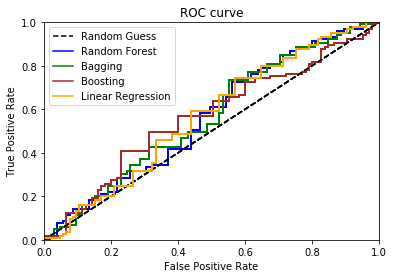

In [111]:
auc_rf = plot_roc_curve_plus_auc(y_test_binary, rf_prediction_prob, 'blue', 'Random Forest', 1,pos_label=1)
auc_bagging = plot_roc_curve_plus_auc(y_test_binary, bag_prediction_prob,'green', 'Bagging', 1,pos_label=1)
auc_boosting = plot_roc_curve_plus_auc(y_test_binary, boost_prediction_prob,'brown', 'Boosting',1, pos_label=1)
auc_lr = plot_roc_curve_plus_auc(y_test_binary, lr_prediction_prob,'orange', 'Linear Regression',1, pos_label=1)

#plt.savefig(plot_path+"ROC Curve_1")

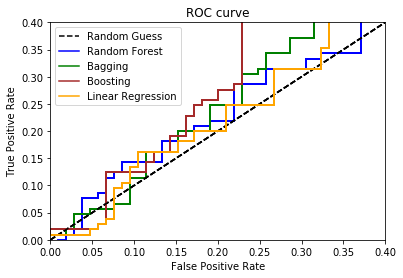

In [112]:
#ROC Curve with 0.4 of xlim/ylim
auc_rf = plot_roc_curve_plus_auc(y_test_binary, rf_prediction_prob, 'blue', 'Random Forest', 0.4,pos_label=1)
auc_bagging = plot_roc_curve_plus_auc(y_test_binary, bag_prediction_prob,'green', 'Bagging', 0.4,pos_label=1)
auc_boosting = plot_roc_curve_plus_auc(y_test_binary, boost_prediction_prob,'brown', 'Boosting',0.4, pos_label=1)
auc_lr = plot_roc_curve_plus_auc(y_test_binary, lr_prediction_prob,'orange', 'Linear Regression',0.4, pos_label=1)

#plt.savefig(plot_path+"ROC Curve_2")

In [113]:
auc_dic = {"auc_rf":auc_rf,"auc_bagging":auc_bagging,"auc_boosting":auc_boosting, "auc_lr":auc_lr}

for i in auc_dic.keys():
    print('ROC AUC',i, ': %.4f' % auc_dic[i])

ROC AUC auc_rf : 0.5492
ROC AUC auc_bagging : 0.5506
ROC AUC auc_boosting : 0.5464
ROC AUC auc_lr : 0.5451


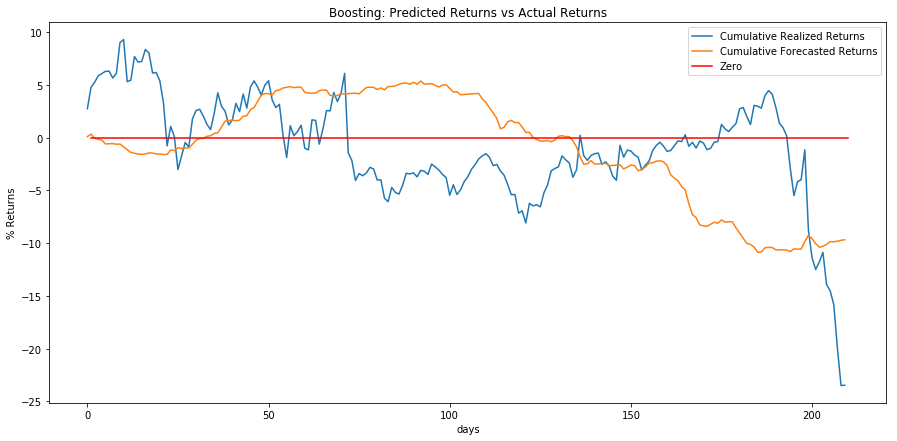

In [114]:
# plot best model which is boosting
plt.figure(figsize=(15, 7))
plt.plot(sc.inverse_transform(np.array(y_test[0:210])).cumsum())
plt.plot(sc.inverse_transform(boost_prediction).cumsum())
plt.plot(list(range(1,210+1)), np.array([0] * 210), 'b-', color="red", label='Zero')
plt.legend(["Cumulative Realized Returns","Cumulative Forecasted Returns","Zero"])

plt.ylabel('% Returns')
plt.xlabel('days')
plt.title('Boosting: Predicted Returns vs Actual Returns')
#plt.savefig(plot_path+'Boosting_Pred_Returns_vs_Actual_Returns')
plt.show()